This one covers activations and gradients (and diagnostic stats and visualizations), batchnorm, and a 'pytorchification' of all of the previous work that wraps previous code in an API that looks like PyTorch w/ classes for layers, etc.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))

stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}

vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length, how many chars to predict next char?

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        # training row for each set of block_size chars (with '.' at end)
        for ch in w + '.':
            ix = stoi[ch] # 'next' char, after context
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # new context shifts right and adds prev 'next' char
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words)) # 80% for train
n2 = int(0.9*len(words)) # 10% for dev/validation and test

Xtr,  Ytr = build_dataset(words[:n1])    # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte,  Yte = build_dataset(words[n2:])    # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
# MLP (revisited, he says)
n_embd = 10 # dimensionality of character embedding vectors
n_hidden = 200 # number of neurons in MLP hidden layer(s)

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

11897


In [11]:
# same optimization (to start) as the end of video two
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed chars into vectors
    embcat = emb.view(emb.shape[0], -1) # concat the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
        
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print occasionally
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 26.9945
  10000/ 200000: 2.4082
  20000/ 200000: 2.1997
  30000/ 200000: 2.2095
  40000/ 200000: 2.3114
  50000/ 200000: 2.0961
  60000/ 200000: 2.2502
  70000/ 200000: 2.5068
  80000/ 200000: 2.9409
  90000/ 200000: 2.5324
 100000/ 200000: 2.7696
 110000/ 200000: 2.1313
 120000/ 200000: 2.2607
 130000/ 200000: 2.3955
 140000/ 200000: 2.0824
 150000/ 200000: 2.3267
 160000/ 200000: 2.6652
 170000/ 200000: 2.1866
 180000/ 200000: 2.0533
 190000/ 200000: 1.9721


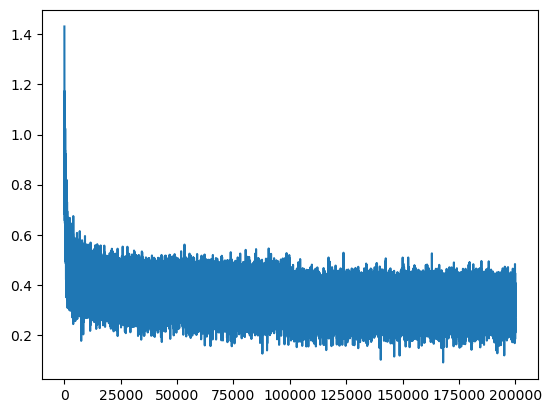

In [14]:
plt.plot(lossi)

In [10]:
@torch.no_grad() # no gradient tracking needed for inference
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat to (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.0376641750335693
val 2.106989622116089


In [16]:
# sample from/inference using the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # init w/ ...
    while True:
        # forward pass
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the prob dist
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out))

carlah.
amelle.
khi.
miliathtyn.
kansh.
esrahnel.
delynn.
jareen.
ner.
keah.
maiir.
kaleigh.
ham.
jorn.
quint.
saline.
liveni.
waxtan.
dearynix.
kael.


# Stuff we can improve - initialization

First off, he talks about how the model's not initialized well, to start with because the first loss is very high - for ex, it's ~28 above. This is high compared to what it very quickly gets to - just 10K iterations/the next time we look, it's at 2.8. 

More importantly, initially, without having seen any data, we'd expect the model to assign roughly equal probabilities to all of the 27 outcomes.

In [17]:
# approx loss if we had uniform prob 
-torch.tensor(1/27.0).log()

tensor(3.2958)

The above is an order of magnitude lower than what we actually see. This happens because the random values we assign during initialization end up producing probabilities that are very strong - high (absolute) values - when what we want is logits that are very close to zero.

We can get them close to zero by adding a '* 0' - for bias - or '* 0.1' or other small number - for weights. (Generally better to have it be a small number and not zero because there's some pathological behavior, that he named but didn't explain early on at least that zero can cause.)

In [23]:
# MLP (revisited, he says)
n_embd = 10 # dimensionality of character embedding vectors
n_hidden = 200 # number of neurons in MLP hidden layer(s)

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

11897


In [27]:
# same optimization (to start) as the end of video two
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed chars into vectors
    embcat = emb.view(emb.shape[0], -1) # concat the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
        
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print occasionally
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break

      0/ 200000: 2.2264


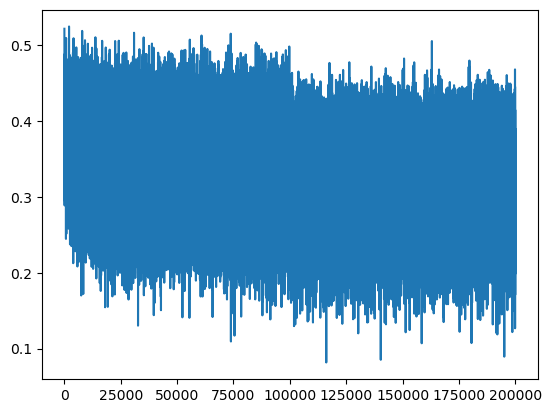

In [25]:
plt.plot(lossi)

In [26]:
split_loss('train')
split_loss('val')

train 2.0695888996124268
val 2.131074905395508


Now, we don't have the hockey stick appearance because we 'don't have to spend the first iterations squashing down the logits' and only then 'rearranging the logits'. This leads to better loss numbers because we can get immediately to optimizing and don't have to spend iterations on that 'squashing down'.

The second 'deeper' problem is still w/ the values of h - the activations of the hidden layer. If we stop after one iteration and plot a histogram with the results of the h/post tanh layer we see that the vast majority of the weights are at the extreme either end of the distribution. This happens because the tanh is a squashsing function - it returns between -1 and 1 - and the values we're feeding into the tanh are almost always less than -1 or greater than 1. 

Extreme values like this 'stop the back propagation'/'gradients will be destroyed' because the values fed in are at flat parts of the tanh curve, and the flatness means that the you can change the input and the loss won't be affected (much). 

We can see this by adding the break above so we only get one iteration, and then looking at the 'h' weights.

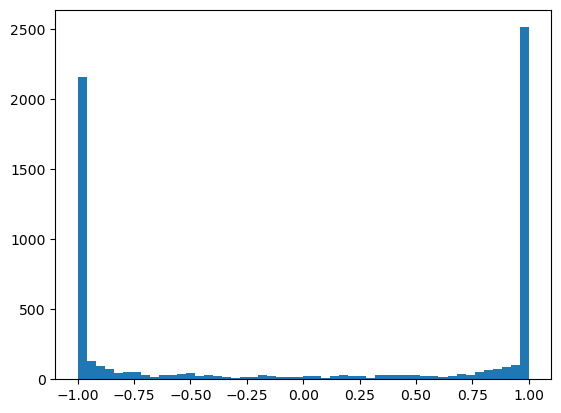

In [29]:
plt.hist(h.view(-1).tolist(), 50); # semicolon suppresses text output

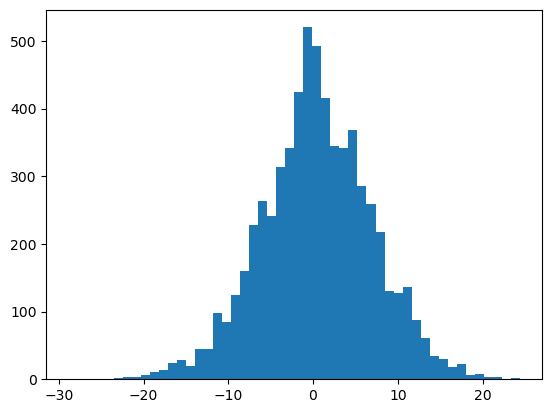

In [30]:
plt.hist(hpreact.view(-1).tolist(), 50); # semicolon suppresses text output

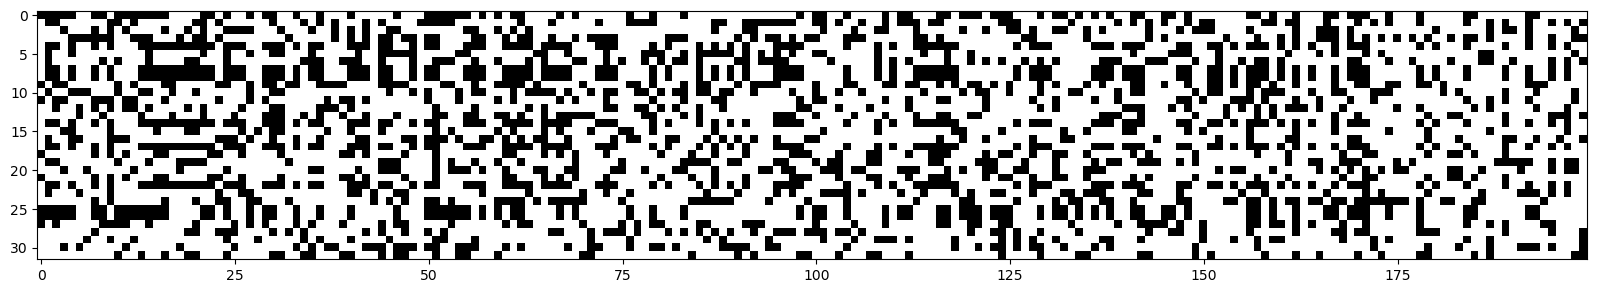

In [33]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

The above has 32 rows, one for each input in the minibatch, and 200 columns, one for each node in the hidden layer. Each place where a cell is white is one where the absolute value of the weight is > 0.99. 

First off, any column where all cells are white would indicate a 'dead neuron'. None are here. If we did see this, that'd mean that the particular neuron never learns/doesn't do anything for us - i.e., no matter what inputs the neuron gets, it always fires with a 1 or -1 and so it doesn't learn because the gradient is zeroed out. Since we don't see this, at least we can say that some of the time - with some inputs - each neuron learns. 

Then he talks about some common activation functions, many of which have flat areas and so are potentially susceptible to this kind of problem (leaky relu is one that isn't or is less susceptible because the line < 0 isn't quite flat). He also mentions how sometimes too big of a learning rate can cause neurons to zero out/be dead. 

Generally, we want values that go into the tanh - hpreact - to be a lot closer to zero. The hpreact data comes from the matmul with W1 and b1, so we'll go ahead and multiply by a 10th or 100th like we did w/ the other layer.

In [34]:
# MLP (revisited, he says)
n_embd = 10 # dimensionality of character embedding vectors
n_hidden = 200 # number of neurons in MLP hidden layer(s)

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

11897


In [39]:
# same optimization (to start) as the end of video two
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed chars into vectors
    embcat = emb.view(emb.shape[0], -1) # concat the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
        
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print occasionally
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    #break

      0/ 200000: 3.2465
  10000/ 200000: 1.9043
  20000/ 200000: 1.9004
  30000/ 200000: 1.9465
  40000/ 200000: 2.1656
  50000/ 200000: 2.0071
  60000/ 200000: 2.0826
  70000/ 200000: 2.4228
  80000/ 200000: 2.3109
  90000/ 200000: 2.1167
 100000/ 200000: 2.2166
 110000/ 200000: 1.8038
 120000/ 200000: 2.2112
 130000/ 200000: 1.9618
 140000/ 200000: 1.8056
 150000/ 200000: 2.4102
 160000/ 200000: 2.1829
 170000/ 200000: 1.6967
 180000/ 200000: 1.9343
 190000/ 200000: 2.1057


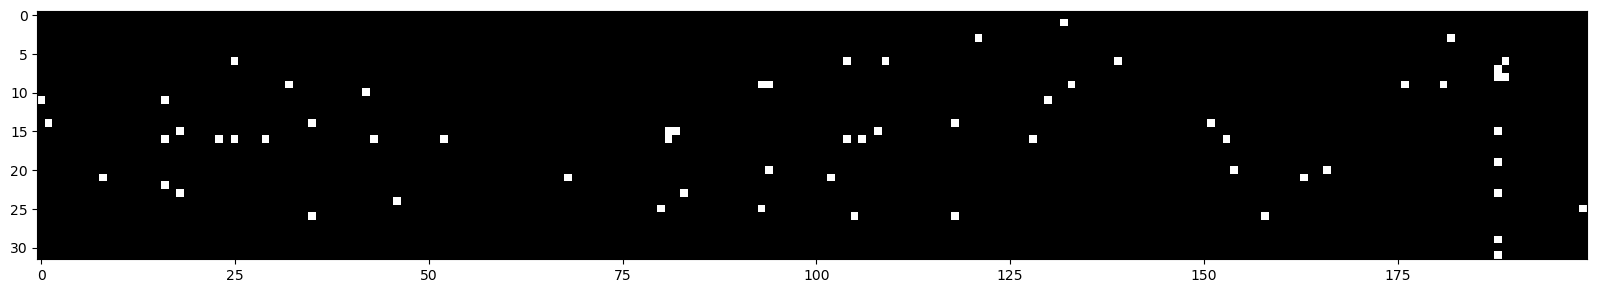

In [36]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

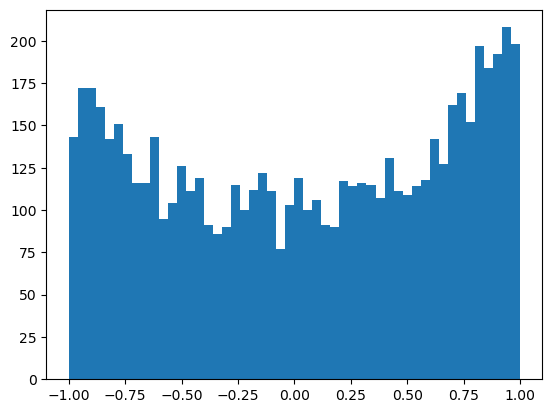

In [37]:
plt.hist(h.view(-1).tolist(), 50); # semicolon suppresses text output

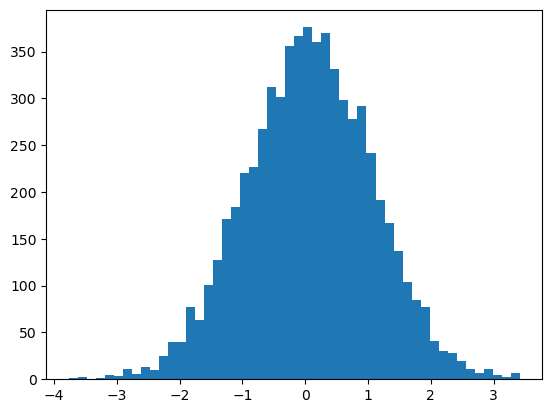

In [38]:
plt.hist(hpreact.view(-1).tolist(), 50); # semicolon suppresses text output

The above is much better - hpreact is closer to zero and only a very few neurons end up white/would zero out.

And the loss is improved. He notes that we started w/ a validation loss of 2.17, by fixing the softmax being confidently wrong we got to 2.13, and by fixing the tanh layer being too saturated at initialization we got down to 2.10.

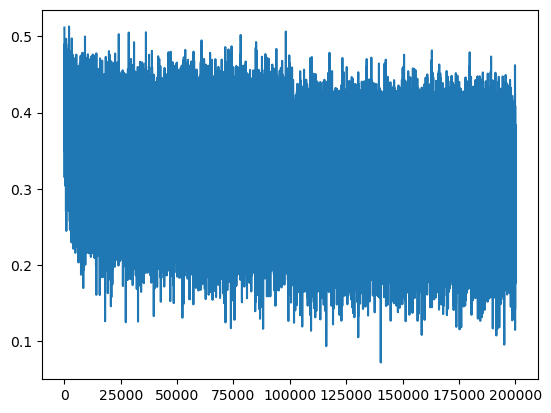

In [41]:
plt.plot(lossi)

In [40]:
split_loss('train')
split_loss('val')

train 2.0357086658477783
val 2.1029489040374756


He notes that we have a very small/shallow network, which makes things pretty resilient to bad initialization. This isn't the case when we have bigger models - like 50 layers - and in some cases things like bad initialization can keep a model from optimizing at all. The bigger the model, the more problems we may have.

# How to make numbers smaller automatically, starting with Kaiming initialization

"No one sets [the '* 0.01' (like)] numbers we set manually above manually" - instead they use techniques like the ones in this section to set them automatically.

Without any adjustment, we can see the variance of subsequent layers get larger, when we want the variance to stay roughly the same. One approach to doing this is to divide the values in the second part of the matmul by the square root of the fan in. So, if we have a second tensor that's (10, 200), we divide by the square root of 10 (same as raise 10 to the power of 0.5).

Ultimately what we want is for a network where the 'activations are well-behaved' - where they don't go to infinity or zero. He discussed this in the paper called "Delving deep into rectifiers" by Kaiming et al. This paper studies ReLU activations, which clamp all negative inputs to zero and pass through all positive inputs. To get the well-behaved network here, you need to compensate for the 'throwing away of half the distribution' with a gain - they use square root of 2 divided by the fan in (vs our prev paragraph w/ sqrt of 1/n). The paper also studies the backprop, and find that if you properly initialize the weights, you empirically don't need to do anything to make backprop work.

PyTorch has torch.nn.init_kaiming_normal_, which is "probably the most commonly used way to init neural networks now". This includes a param that adjusts the gain depending on the type of non-linearity.

Then he said he 'was going through the above pretty quickly' because a lot of it's no longer needed, due to further advances since the paper was written 7-8 years ago. Back then, you had to be super careful with init, etc. especially w/ deep networks, or they wouldn't train. Now, w/ 'advancements' it's a lot less important. 

These advancements include:

- residual connections (to come)
- using many normalization layers - batch normalization, layer normalization, etc.
- much better optimizers - no longer just SGD, but 'armas prop' (sp?) and 'adam' (also sp?).

Ultimately, what does he do in practice today? He normalizes by dividing by the square root of the fan-in, and leaves it at that, or he's a bit more complicated and uses the gain, like 5/3 for tanh. You can also use the kaiming function in pytorch, I think.

So, I'll do it here - he gets the same loss as above, but the key is that we get this w/o any magic numbers that have to be set manually - like the initial 0.2 that we got by trying different numbers and seeing what worked well. Instead, these are automatically set and give good results.

In [6]:
# MLP, now with kaiming initialization (for W1)
n_embd = 10 # dimensionality of character embedding vectors
n_hidden = 200 # number of neurons in MLP hidden layer(s)

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

11897


In [7]:
# same optimization (to start) as the end of video two
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed chars into vectors
    embcat = emb.view(emb.shape[0], -1) # concat the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
        
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print occasionally
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    #break

      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9752
 190000/ 200000: 1.8614


In [11]:
split_loss('train')
split_loss('val')

train 2.0376641750335693
val 2.106989622116089


# Batch normalization (one reason initialization doesn't matter as much anymore)

He talked about the Ioffe and Szegedy paper on batch normalization - a 'very impactful paper that made it possible to train deep NNs and it basically just worked'.

This is at 41m.

Ultimately we want the pre-activation numbers to not be too small (because they won't do anything) or too big (because then they saturate the tanh activation) - he says we want them to be roughly gaussian with mean 0 and std of 1 (all at least at initialization). The insight of the batch normalization paper is that if you want them to be gaussian, you can just normalize them to be gaussian. That normalization is a differentiable operation and so everything just works. 

What's the normalization operation? Just standardization: calculate the mean and std (of all the training examples, for each neuron at the layer, I'm pretty sure - i.e., hpreact - the pre-activation numbers - are size (32, 200) for a minibatch of 32 and a 200 neuron hidden layer, and the mean and std is of the zeroth dimension of hpreact, which gives a size (1, 200)). And then subtract the mean and divide by the stddev.

And again, we only want this normalization - to make each value (all 32 of them) be distributed as a std gaussian - to happen at initialization. After initialization, we want to let backprop make the distribution wider or narrower, make it peak near the activation thresholds, etc. The paper calls this 'scale and shift', with new parameters: a batch normalization gain (init to all ones and size (1, 200) and bias (to all zeros, also (1, 200). We use these in the normalization calcs for each iteration - since they start at 1, we get full gaussian normalization at the start, and then since they're parameters of the network, backprop can adjust to the best values given the data.

In [12]:
# MLP, now with kaiming initialization (for W1)
n_embd = 10 # dimensionality of character embedding vectors
n_hidden = 200 # number of neurons in MLP hidden layer(s)

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# batch normalization parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

12297


In [14]:
# same optimization (to start) as the end of video two
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed chars into vectors
    embcat = emb.view(emb.shape[0], -1) # concat the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    # batch normalization
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
        
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print occasionally
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    #break

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


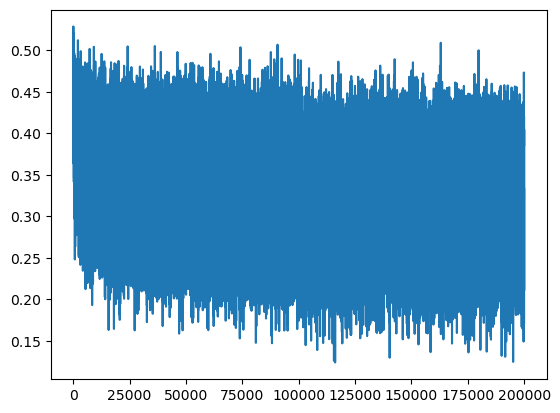

In [16]:
plt.plot(lossi)

In [15]:
@torch.no_grad() # no gradient tracking needed for inference
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat to (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1 
    # batch normalization
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.0668270587921143
val 2.104844808578491


The loss is basically what we've seen before. This is what he'd expect, because this is a very simple network and we'd been able to manually calculate the normalization values that we needed to get things to be roughly normal. 

However, with more complicated networks we'd have a _much_ harder time doing this manual evaluation and adjustment so that we get gaussian layers throughout the network. Instead, what people do is 'sprinkle batch normalization layers throughout - for ex after each linear and convolution layer (being like a linear layer but more spatially focused) to control the scale of the activations throughout the neural net'. This is super easy to add and just works.

It does 'come at a significant (possible) cost'. The new thing is that our output - ultimately the logits/log probabilities for each of the 27 characters, in this work - is now not deterministic. Instead, the output is 'coupled mathematically' w/ the particular items chosen at random to be part of each batch. Before, we had randomness in what we included in each batch, but each row/col/part of the matrix multiplication was still only controlled by the particular input data, and so the outputs we're also only dependent on the input data. With batch normalization, the values for any given row of input data depend on the input data but also, now, on the other, in our case 31, rows of input data that were randomly determined to be part of the minibatch, since the mean and std that we use depends on all of the rows.

However, he says while this might seem undesirable, it's actually good. Effectively, it's a regularization step that makes it harder for the neural net to overfit. 

Still, people don't like the mathematical coupling - I think he says it can lead to bugs. So folks have tried different kinds of automatic normalization (he listed a few, like group normalization), but these have had a hard time overcoming batch normalization because - I think he implied - the regularization is a good and powerful thing.

## How to predict, after batch normalization

Given a trained model, we want to be able to feed in a single input and get a set of logits. But now, with batch normalization, we expect a batch as input, so we can calc the mean and std and do the normalization operations.

The paper says to fix this by doing a post-training step where the mean and std are calculated, one time, based on all of the training data. And then these values are used when we predict. He shows code that does this around 56m.

In practice, however, what folks normally do is avoid the post-training step by doing a running calc during training and using that at the end. The code below is updated to implement this. He also says it's the way the batch normalization layer provided by PyTorch works.

In [17]:
# MLP
n_embd = 10 # dimensionality of character embedding vectors
n_hidden = 200 # number of neurons in MLP hidden layer(s)

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# batch normalization parameters, now w/ running totals
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

12297


In [18]:
# same optimization (to start) as the end of video two
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed chars into vectors
    embcat = emb.view(emb.shape[0], -1) # concat the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    # batch normalization, now w/ running totals
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        # running totals aren't used in backprop
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
        
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print occasionally
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    #break

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


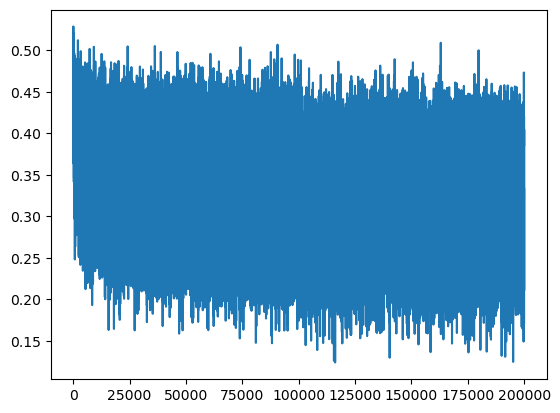

In [19]:
plt.plot(lossi)

In [20]:
@torch.no_grad() # no gradient tracking needed for inference
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat to (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1 
    # batch normalization, now using result of running totals
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.066591501235962
val 2.1050572395324707


## A few more things

He talked about how in practice you add a small epsilon value to the scale and shift calcs to avoid a divide by zero error when you have a variance of zero. In our case we're not going to see it w/ this network, so the code doesn't do it.

Also, he mentioned how the b1 bias numbers are worthless now since we've implemented batch normalization. The calcs add them when creating hpreact, but then the normalization just subtracts it out (and if you look at b1.grad, he says it'll just be zero). Instead, the bnbias value is what adds in the bias for the layer. As a result, when you use batch normalization w/ a linear or conv layer, you typically skip the bias term, like the code below does.

In [22]:
# MLP
n_embd = 10 # dimensionality of character embedding vectors
n_hidden = 200 # number of neurons in MLP hidden layer(s)

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# batch normalization parameters, now w/ running totals
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

12097


In [23]:
# same optimization (to start) as the end of video two
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed chars into vectors
    embcat = emb.view(emb.shape[0], -1) # concat the vectors
    hpreact = embcat @ W1 # no more b1 since we're using batch norm
    # batch normalization, now w/ running totals
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        # running totals aren't used in backprop
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
        
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print occasionally
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    #break

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


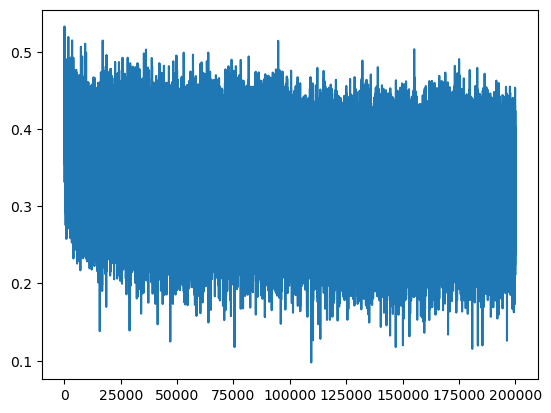

In [24]:
plt.plot(lossi)

In [26]:
@torch.no_grad() # no gradient tracking needed for inference
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat to (N, block_size * n_embd)
    hpreact = embcat @ W1 #+ b1 
    # batch normalization, now using result of running totals
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.0674145221710205
val 2.1056838035583496


## Final code with comments, including batch normalization

In [27]:
# MLP
n_embd = 10 # dimensionality of character embedding vectors
n_hidden = 200 # number of neurons in MLP hidden layer(s)

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# batch normalization parameters, now w/ running totals
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

12097


In [28]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed chars into vectors
    embcat = emb.view(emb.shape[0], -1) # concat the vectors

    # linear layer
    hpreact = embcat @ W1 # hidden layer pre-activation
    
    # batch normalization
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    # non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
        
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print occasionally
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    #break

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


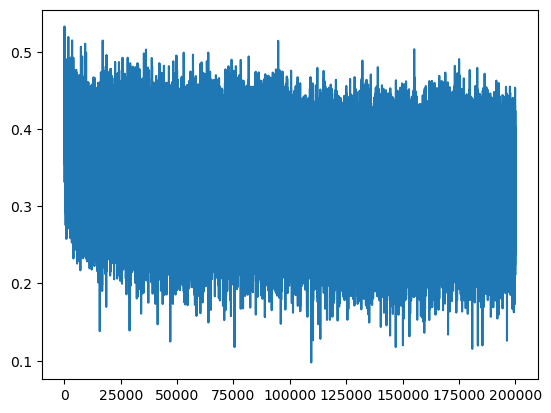

In [29]:
plt.plot(lossi)

In [30]:
split_loss('train')
split_loss('val')

train 2.0674145221710205
val 2.1056838035583496


# ResNet and PyTorch, compared with what we've implemented ('residual neural net')

Starts at 1:04:45 or so. The example he shows is a bunch of: conv layer, batch normalization, relu, like what we've done. (Conv layers are like our linear layers - with input @ weights + bias - aka 'Wx+b', but they're done on 'patches'/subsets of the input, to reflect parts of an image, instead of on all the input. The example he uses is at https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py.

Then he talks about the [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layer defined in PyTorch. It uses a uniform distribution for init, not our gaussian distribution. 

And then about the [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) layer. He discusses how smaller batch sizes (like 32) probably want momentum of 0.01 or 0.001 instead of the default that I think's 0.1, because smaller batch sizes jump around more than larger batch sizes, and so we don't want to trust them as much. (The momentum is like the constant we use when updating the mean/std as we calc.)

# Summary 

This starts around 1:14. Main point of the lecture is that you need to understand how activations work, especially as your networks get bigger, so you can get reasonable training via backprop. Ultimately we want roughly gaussian activations throughout so we keep signal. Batch normalization layers give us this in a scalable way. He does recommend using something like group normalization or layer normalization instead - these are more recent, and don't cause as many bugs as batch normalization. Batch normalization was a great advance, but has been superceded by better operations.

# Bonus: Using our impl but in a more PyTorch style

Starts at 1:18:30. He takes the code we've already written above and wraps it in a more PyTorch-like set of abstractions/structure, and then also adds some new visualizations to understand activations in both the forward and backward passes.

In [34]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        # out var isn't in PyTorch - here so we can graph/examine results
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        # returns tensors
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
    
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # calc the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True, unbiased=True) # batch var
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # and update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
    
n_embd = 10 # dimensionality of the character embedding vectors
n_hidden = 100 # neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd),              generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(n_hidden,            n_hidden), Tanh(),
    Linear(n_hidden,            n_hidden), Tanh(),
    Linear(n_hidden,            n_hidden), Tanh(),
    Linear(n_hidden,            n_hidden), Tanh(),
    Linear(n_hidden,            vocab_size),
]

with torch.no_grad():
    # last layer - make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # total num of params
for p in parameters:
    p.requires_grad = True

46497


In [35]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed chars into vectors
    x = emb.view(emb.shape[0], -1) # concat the vectors
    for layer in layers:
        x = layer(x) # call __call__ for each layer so the layer can do its job
    loss = F.cross_entropy(x, Yb)

    # none of the following needed explicitly now because all of it is
    # in the impl of each layer, as defined above
#     # linear layer
#     hpreact = embcat @ W1 # hidden layer pre-activation
    
#     # batch normalization
#     bnmeani = hpreact.mean(0, keepdim=True)
#     bnstdi = hpreact.std(0, keepdim=True)
#     hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
#     with torch.no_grad():
#         bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
#         bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
#     # non-linearity
#     h = torch.tanh(hpreact) # hidden layer
#     logits = h @ W2 + b2 # output layer
#     loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_grad
    for p in parameters:
        p.grad = None
    loss.backward()
        
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print occasionally
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break

      0/ 200000: 3.2962


layer 1 (      Tanh): mean -0.02, std 0.75, saturated: 20.25%
layer 3 (      Tanh): mean -0.00, std 0.69, saturated: 8.38%
layer 5 (      Tanh): mean +0.00, std 0.67, saturated: 6.62%
layer 7 (      Tanh): mean -0.01, std 0.66, saturated: 5.47%
layer 9 (      Tanh): mean -0.02, std 0.66, saturated: 6.12%


Text(0.5, 1.0, 'activation distribution')

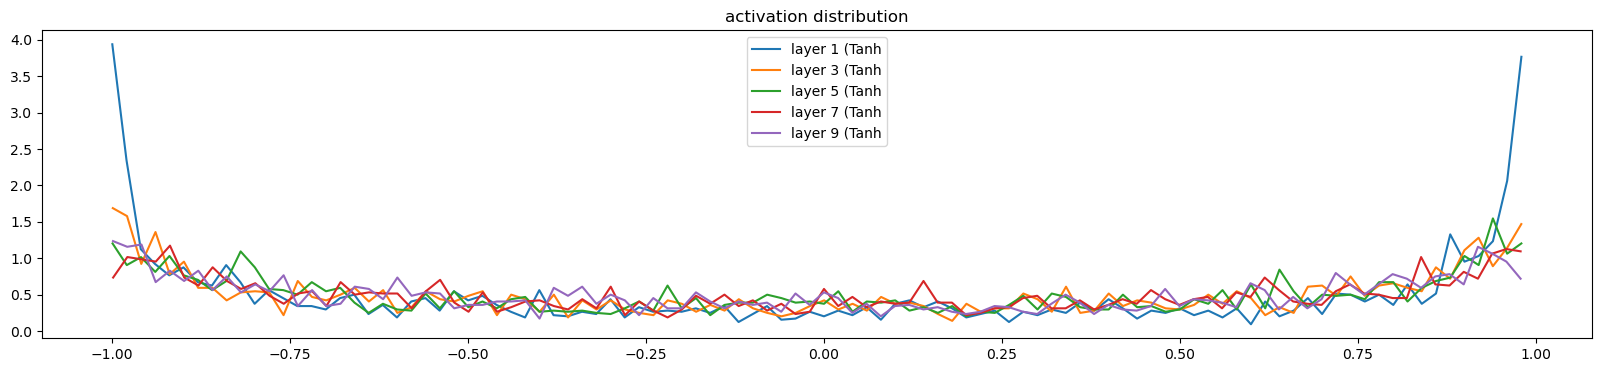

In [37]:
# visualize histogram
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # exclude output layer
    if isinstance(layer, Tanh): # just show vals at Tanh - since these are [-1,1] they're easy to look at together
        t = layer.out
        # saturation is defined as being in the tails - -1 to -0.97 or 0.97 to 1, this is where the gradient stops flowing
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')

The above is a pretty good result - it stabilizes with all but the first layer having roughly similar std devs and some but not extensive saturation, which is what we want. He says we're getting this because we're setting each time a gain of 5/3. If we set the gain to 1 instead, then what we'd see is that the std dev would get smaller and smaller for each layer. This occurs because the Tanh layer is squashing layer and w/o anything additional would squash to zero eventually. The gain counteracts this squashing. Empirically, 5/3 is a good value for the gain - he doesn't know where this number comes from. (If we use too much gain then we'd end up with too much of the activation being in the saturation/tails of the distribution.)

We can also do the same thing w/ the gradients. Same code, except we're looking at the .grad values.

layer 1 (      Tanh): mean +0.000010, std 4.205588e-04
layer 3 (      Tanh): mean -0.000003, std 3.991179e-04
layer 5 (      Tanh): mean +0.000003, std 3.743020e-04
layer 7 (      Tanh): mean +0.000015, std 3.290473e-04
layer 9 (      Tanh): mean -0.000014, std 3.054035e-04


Text(0.5, 1.0, 'gradient distribution')

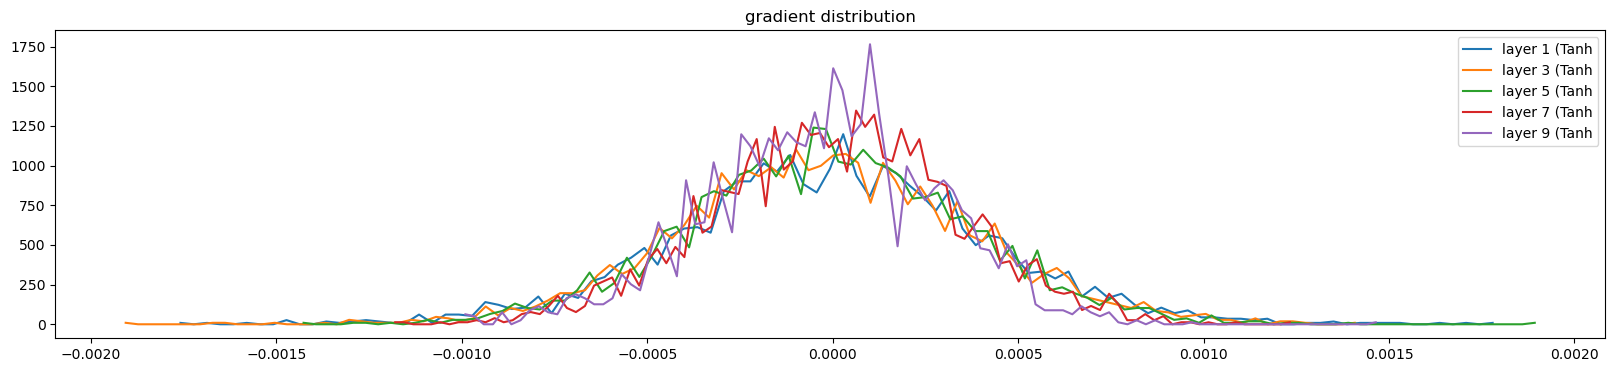

In [40]:
# visualize histogram
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # exclude output layer
    if isinstance(layer, Tanh): # just show vals at Tanh - since these are [-1,1] they're easy to look at together
        t = layer.out.grad
        # saturation is defined as being in the tails - -1 to -0.97 or 0.97 to 1, this is where the gradient stops flowing
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution')

This is also good. What we want is for all the different layers to have roughly the same gradient - things aren't shrinking or exploding - beacuse the gain is a good value. If instead we have too small or too large gain values then we'd see significantly different magnitudes for the gradients depending on the layer.

So we try 5/3 and it works - if it didn't, since we're not using batch normalization in the above, we'd have to manually play w/ different gain values to get something that ultimately works/doesn't shrink or explode. (And this is harder the bigger/deeper the network gets.)

And again, this is what it used to be like before batch normalization and before better optimizers - he showed images of balancing a pencil on your fingertip.

Stopping at 1:36:30 where he starts talking about a plot that shows grad:data ratio.